In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score, mean_absolute_error

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter


In [3]:
filesList = os.listdir('../src')
print(filesList)

['soil_data.csv', 'train_timeseries', 'counties.geojson', 'test_timeseries', 'validation_timeseries', 'counties.zip']


In [4]:
dataDic = {"train": pd.read_csv("../src/train_timeseries/train_timeseries.csv"),
           "test": pd.read_csv("../src/test_timeseries/test_timeseries.csv"),
           "validation": pd.read_csv("../src/validation_timeseries/validation_timeseries.csv"),
           "soil" : pd.read_csv("../src/soil_data.csv"),
           }

In [5]:
# dataDic["train"].columns

In [6]:
# dataDic["soil"]

In [7]:
class2id = {
    'None': 0,
    'D0': 1,
    'D1': 2,
    'D2': 3,
    'D3': 4,
    'D4': 5,
}
id2class = {v: k for k, v in class2id.items()}

In [8]:
dfs = {
    k: dataDic[k].set_index(['fips', 'date'])
    for k in dataDic.keys() if k != "soil"
}

dfs["soil"] = dataDic["soil"]

In [36]:
batch_size = 128
output_weeks = 6
use_static = True
hidden_dim = 512
n_layers = 2
ffnn_layers = 2
dropout = 0.1
embeddings_dim = [570, 4, 4, 4, 4, 4, 4, 4]
one_cycle = True
lr = 8e-5 # 9e-5
epochs = 10
clip = 5


In [10]:
def interpolate_nans(padata, pkind='linear'):
    """
    see: https://stackoverflow.com/a/53050216/2167159
    """
    aindexes = np.arange(padata.shape[0])
    agood_indexes, = np.where(np.isfinite(padata))
    f = interp1d(agood_indexes
               , padata[agood_indexes]
               , bounds_error=False
               , copy=False
               , fill_value="extrapolate"
               , kind=pkind)
    return f(aindexes)

In [11]:
def date_encode(date):
    if isinstance(date, str):
        date = datetime.strptime(date, "%Y-%m-%d")
    return (
        np.sin(2 * np.pi * date.timetuple().tm_yday / 366),
        np.cos(2 * np.pi * date.timetuple().tm_yday / 366),
    )

In [12]:
def loadXY(
    df,
    random_state=42,
    window_size=180, # how many days in the past (default/competition: 180)
    target_size=6, # how many weeks into the future (default/competition: 6)
    fuse_past=True, # add the past drought observations? (default: True)
    return_fips=False, # return the county identifier (do not use for predictions)
    encode_season=True, # encode the season using the function above (default: True) 
    use_prev_year=False, # add observations from 1 year prior?
):
    df = dfs[df]
    soil_df = dfs["soil"]
    time_data_cols = sorted(
        [c for c in df.columns if c not in ["fips", "date", "score"]]
    )
    static_data_cols = sorted(
        [c for c in soil_df.columns if c not in ["soil", "lat", "lon"]]
    )
    count = 0
    score_df = df.dropna(subset=["score"])
    X_static = np.empty((len(df) // window_size, len(static_data_cols)))
    X_fips_date = []
    add_dim = 0
    if use_prev_year:
        add_dim += len(time_data_cols)
    if fuse_past:
        add_dim += 1
        if use_prev_year:
            add_dim += 1
    if encode_season:
        add_dim += 2
    X_time = np.empty(
        (len(df) // window_size, window_size, len(time_data_cols) + add_dim)
    )
    y_past = np.empty((len(df) // window_size, window_size))
    y_target = np.empty((len(df) // window_size, target_size))
    if random_state is not None:
        np.random.seed(random_state)
    for fips in tqdm(score_df.index.get_level_values(0).unique()):
        if random_state is not None:
            start_i = np.random.randint(1, window_size)
        else:
            start_i = 1
        fips_df = df[(df.index.get_level_values(0) == fips)]
        X = fips_df[time_data_cols].values
        y = fips_df["score"].values
        X_s = soil_df[soil_df["fips"] == fips][static_data_cols].values[0]
        for i in range(start_i, len(y) - (window_size + target_size * 7), window_size):
            X_fips_date.append((fips, fips_df.index[i : i + window_size][-1]))
            X_time[count, :, : len(time_data_cols)] = X[i : i + window_size]
            if use_prev_year:
                if i < 365 or len(X[i - 365 : i + window_size - 365]) < window_size:
                    continue
                X_time[count, :, -len(time_data_cols) :] = X[
                    i - 365 : i + window_size - 365
                ]
            if not fuse_past:
                y_past[count] = interpolate_nans(y[i : i + window_size])
            else:
                X_time[count, :, len(time_data_cols)] = interpolate_nans(
                    y[i : i + window_size]
                )
            if encode_season:
                enc_dates = [
                    date_encode(d) for f, d in fips_df.index[i : i + window_size].values
                ]
                d_sin, d_cos = [s for s, c in enc_dates], [c for s, c in enc_dates]
                X_time[count, :, len(time_data_cols) + (add_dim - 2)] = d_sin
                X_time[count, :, len(time_data_cols) + (add_dim - 2) + 1] = d_cos
            temp_y = y[i + window_size : i + window_size + target_size * 7]
            y_target[count] = np.array(temp_y[~np.isnan(temp_y)][:target_size])
            X_static[count] = X_s
            count += 1
    print(f"loaded {count} samples")
    results = [X_static[:count], X_time[:count], y_target[:count]]
    if not fuse_past:
        results.append(y_past[:count])
    if return_fips:
        results.append(X_fips_date)
    return results

In [13]:
scaler_dict = {}
scaler_dict_static = {}
scaler_dict_past = {}


def normalize(X_static, X_time, y_past=None, fit=False):
    for index in tqdm(range(X_time.shape[-1])):
        if fit:
            scaler_dict[index] = RobustScaler().fit(X_time[:, :, index].reshape(-1, 1))
        X_time[:, :, index] = (
            scaler_dict[index]
            .transform(X_time[:, :, index].reshape(-1, 1))
            .reshape(-1, X_time.shape[-2])
        )
    for index in tqdm(range(X_static.shape[-1])):
        if fit:
            scaler_dict_static[index] = RobustScaler().fit(
                X_static[:, index].reshape(-1, 1)
            )
        X_static[:, index] = (
            scaler_dict_static[index]
            .transform(X_static[:, index].reshape(-1, 1))
            .reshape(1, -1)
        )
    index = 0
    if y_past is not None:
        if fit:
            scaler_dict_past[index] = RobustScaler().fit(y_past.reshape(-1, 1))
        y_past[:, :] = (
            scaler_dict_past[index]
            .transform(y_past.reshape(-1, 1))
            .reshape(-1, y_past.shape[-1])
        )
        return X_static, X_time, y_past
    return X_static, X_time

In [14]:
# X_tabular_train, X_time_train, y_target_train = loadXY("train", use_prev_year=True)
# print("train shape", X_time_train.shape)
# X_tabular_validation, X_time_valid, y_target_valid, valid_fips = loadXY("validation", return_fips=True, use_prev_year=True)
# print("validation shape", X_time_valid.shape)
# X_tabular_test, X_time_test, y_target_test, test_fips = loadXY("test", return_fips=True, use_prev_year=True)
# print("test shape", X_time_test.shape)

In [15]:
# # Save all in pickle
# import pickle
# with open("data_no_prev.pkl", "wb") as f:
#     pickle.dump(
#         {
#             "X_tabular_train": X_tabular_train,
#             "X_time_train": X_time_train,
#             "y_target_train": y_target_train,
#             "X_tabular_validation": X_tabular_validation,
#             "X_time_valid": X_time_valid,
#             "y_target_valid": y_target_valid,
#             "valid_fips": valid_fips,
#             "X_tabular_test": X_tabular_test,
#             "X_time_test": X_time_test,
#             "y_target_test": y_target_test,
#             "test_fips": test_fips,
#         },
#         f,
#     )

In [16]:
# import
import pickle
with open("data.pkl", "rb") as f:
    data = pickle.load(f)
X_tabular_train = data["X_tabular_train"]
X_time_train = data["X_time_train"]
y_target_train = data["y_target_train"]
X_tabular_validation = data["X_tabular_validation"]
X_time_valid = data["X_time_valid"]
y_target_valid = data["y_target_valid"]
valid_fips = data["valid_fips"]
X_tabular_test = data["X_tabular_test"]
X_time_test = data["X_time_test"]
y_target_test = data["y_target_test"]
test_fips = data["test_fips"]


In [17]:
X_tabular_train.shape

(97099, 30)

In [18]:
ordered_cols = sorted([c for c in dfs["soil"].columns if c not in ["soil", "lat", "lon"]])

In [19]:
cat_cols = [ordered_cols.index(i) for i in ["fips", "SQ1", "SQ2", "SQ3", "SQ4", "SQ5", "SQ6", "SQ7"]]

In [20]:
cat_cols

[21, 6, 7, 8, 9, 10, 11, 12]

In [21]:
X_tabular_cat_train = X_tabular_train[:,cat_cols].astype(int)
X_tabular_train = X_tabular_train[:,[i for i in range(X_tabular_train.shape[1]) if i not in cat_cols]]

X_tabular_cat_valid = X_tabular_validation[:,cat_cols].astype(int)
X_tabular_validation = X_tabular_validation[:,[i for i in range(X_tabular_validation.shape[1]) if i not in cat_cols]]

X_tabular_cat_test = X_tabular_test[:,cat_cols].astype(int)
X_tabular_test = X_tabular_test[:,[i for i in range(X_tabular_test.shape[1]) if i not in cat_cols]]

In [22]:
X_tabular_cat_test.shape

(2477, 8)

In [23]:
dico_trad = {}
for cat in range(X_tabular_cat_train.shape[1]):
    dico_trad[cat] = {j: i for i,j in enumerate(sorted(np.unique_values(X_tabular_cat_train[:,cat])))}
    dico_trad[cat]["unknown"] = len(np.unique_values(X_tabular_cat_train[:,cat]))

In [24]:
for cat in range(len(cat_cols)):
    X_tabular_cat_train[:,cat] = [dico_trad[cat][i] for i in X_tabular_cat_train[:,cat]]
    X_tabular_cat_valid[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_valid[:,cat]]
    X_tabular_cat_test[:,cat] = [dico_trad[cat][i] if i in dico_trad[cat] else dico_trad[cat]["unknown"] for i in X_tabular_cat_test[:,cat]]

In [25]:
np.unique(X_tabular_cat_train[:,0])

array([   0,    1,    2, ..., 3105, 3106, 3107])

In [26]:
X_tabular_train, X_time_train = normalize(X_tabular_train, X_time_train, fit=True)
X_tabular_validation, X_time_valid = normalize(X_tabular_validation, X_time_valid)
X_tabular_test, X_time_test = normalize(X_tabular_test, X_time_test)

100%|██████████| 22/22 [00:00<00:00, 12283.64it/s]


In [72]:
# export all the data to pickle
import pickle
with open("ready_to_use_data.pkl", "wb") as f:
    pickle.dump(
        {
            "X_time_train": X_time_train,
            "X_tabular_train": X_tabular_train,
            "X_tabular_cat_train": X_tabular_cat_train,
            "y_target_train": y_target_train,
            "X_time_valid": X_time_valid,
            "X_tabular_validation": X_tabular_validation,
            "X_tabular_cat_valid": X_tabular_cat_valid,
            "y_target_valid": y_target_valid,
            "valid_fips": valid_fips,
            "X_time_test": X_time_test,
            "X_tabular_test": X_tabular_test,
            "X_tabular_cat_test": X_tabular_cat_test,
            "y_target_test": y_target_test,
            "test_fips": test_fips,
        },
        f,
    )

: 

In [27]:
#  Prepare the datasets
train_data = TensorDataset(
    torch.tensor(X_time_train),
    torch.tensor(X_tabular_train),
    torch.tensor(X_tabular_cat_train),
    torch.tensor(y_target_train[:, :output_weeks]),
)
valid_data = TensorDataset(
    torch.tensor(X_time_valid),
    torch.tensor(X_tabular_validation),
    torch.tensor(X_tabular_cat_valid),
    torch.tensor(y_target_valid[:, :output_weeks]),
)

# DataLoaders with sampler for training and default for validation
train_loader = DataLoader(
    train_data, batch_size=batch_size, drop_last=False
)

valid_loader = DataLoader(
    valid_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [28]:
test_data = TensorDataset(
    torch.tensor(X_time_test),
    torch.tensor(X_tabular_test),
    torch.tensor(X_tabular_cat_test),
    torch.tensor(y_target_test[:, :output_weeks]),
)

test_loader = DataLoader(
    test_data, shuffle=False, batch_size=batch_size, drop_last=False
)

In [29]:
print(X_time_train.shape, X_tabular_train.shape, X_tabular_cat_train.shape, y_target_train.shape)
print(X_time_valid.shape, X_tabular_validation.shape, X_tabular_cat_valid.shape, y_target_valid.shape)
print(X_time_test.shape, X_tabular_test.shape, X_tabular_cat_test.shape, y_target_test.shape)

(97099, 180, 40) (97099, 22) (97099, 8) (97099, 6)
(2457, 180, 40) (2457, 22) (2457, 8) (2457, 6)
(2477, 180, 40) (2477, 22) (2477, 8) (2477, 6)


In [30]:
len(train_loader)

759

In [31]:
list_cat = [len(np.unique(X_tabular_cat_train[:,i])) + 1 for i in range(X_tabular_cat_train.shape[1])]

In [32]:
list_cat

[3109, 8, 8, 8, 8, 8, 7, 9]

In [33]:
class HybridModel(nn.Module):
    def __init__(
        self,
        num_numerical_features,
        num_time_series_features,
        hidden_size,
        num_lstm_layers,
        list_unic_cat,
        embedding_dims,
        num_fc_tabular_layers,
        num_fc_combined_layers,
        output_size,
        dropout
    ):
        super(HybridModel, self).__init__()
        self.num_lstm_layers = num_lstm_layers
        self.hidden_size = hidden_size

        self.embeddings = nn.ModuleList(
                [
                    nn.Embedding(num_embeddings=i, embedding_dim=dimension)
                    for i, dimension in zip(list_unic_cat, embedding_dims)
                ]
            )
        
        tabular_total_size = num_numerical_features + sum(embedding_dims)
        tabular_fc_layers = []
        for _ in range(num_fc_tabular_layers):
            tabular_fc_layers.append(nn.Linear(tabular_total_size, tabular_total_size))
            tabular_fc_layers.append(nn.ReLU())
        self.tabular_fc_layers = nn.Sequential(
            *tabular_fc_layers, nn.Linear(tabular_total_size, tabular_total_size)
        )

        # TS branch
        self.lstm = nn.GRU(
            input_size=num_time_series_features,
            hidden_size=hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.attention = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

        combined_fc_layers = []
        input_dim = tabular_total_size + hidden_size

        for _ in range(num_fc_combined_layers):
            combined_fc_layers.append(nn.Linear(input_dim, hidden_size))
            combined_fc_layers.append(nn.ReLU())
            input_dim = hidden_size
        self.combined_fc_layers = nn.Sequential(
            *combined_fc_layers, nn.Linear(hidden_size, output_size)
        )

    def forward(self, time_series_data, numerical_data, categorical_data):
        batch_size = time_series_data.size(0)
        h0 = torch.zeros(self.num_lstm_layers, batch_size, self.hidden_size).to(device)

        time_series_data = time_series_data.to(torch.float32)
        numerical_data = numerical_data.to(torch.float32)
        categorical_data = categorical_data.to(torch.int64)

        embeddings = [emb(categorical_data[:, i]) for i, emb in enumerate(self.embeddings)]
        x_cat = torch.cat(embeddings, dim=1)
        x_tabular = torch.cat((x_cat, numerical_data), dim=1)
        x1 = self.tabular_fc_layers(x_tabular)

        # Pass the time series data through the LSTM and the attention mechanism
        lstm_out, _ = self.lstm(time_series_data, h0,)
        lstm_out = self.layer_norm(lstm_out) # Apply layer normalization
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        # Pass the data through the attention mechanism
        # context_vector = lstm_out[:, -1, :]  # Last time step output

        # Combined MLPs and output
        x2 = self.dropout(context_vector)
        x = torch.cat((x1, x2), dim=1)
        x = self.combined_fc_layers(x)
        return x

In [37]:
writer = SummaryWriter('../runs/attention_emb_GRU')

In [38]:
torch.manual_seed(42)
np.random.seed(42)

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("using GPU")
else:
    device = torch.device("cpu")
    print("using CPU")

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=3,
    output_size=output_weeks,
    dropout=dropout,
)

model.to(device)
loss_function = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=len(train_loader), epochs=epochs)
counter = 0
valid_loss_min = np.inf

for i in range(epochs):
    for k, (inputs, static, static_cat, labels) in tqdm(enumerate(train_loader),
                                                       desc=f"epoch {i+1}/{epochs}",
                                                       total=len(train_loader),):
        model.train()
        counter += 1
        inputs, labels, static, static_cat = (
            inputs.to(device),
            labels.to(device),
            static.to(device),
            static_cat.to(device),
        )
        
        model.zero_grad()
        output = model(inputs, static, static_cat)
        loss = loss_function(output, labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            if k == len(train_loader) - 1 or k == (len(train_loader) - 1) // 2:
                val_losses = []
                model.eval()
                labels = []
                preds = []
                raw_labels = []
                raw_preds = []
                for inp, stat, stat_cat, lab in valid_loader:
                    inp, lab, stat, stat_cat = inp.to(device), lab.to(device), stat.to(device), stat_cat.to(device)
                    out = model(inp, stat, stat_cat)
                    val_loss = loss_function(out, lab.float())
                    val_losses.append(val_loss.item())
                    for labs in lab:
                        labels.append([int(l.round()) for l in labs])
                        raw_labels.append([float(l) for l in labs])
                    for pred in out:
                        preds.append([int(p.round()) for p in pred])
                        raw_preds.append([float(p) for p in pred])
                # log data
                labels = np.array(labels)
                preds = np.clip(np.array(preds), 0, 5)
                raw_preds = np.array(raw_preds)
                raw_labels = np.array(raw_labels)
                for i in range(output_weeks):
                    log_dict = {
                        "loss": float(loss),
                        "epoch": counter / len(train_loader),
                        "step": counter,
                        "lr": optimizer.param_groups[0]["lr"],
                        "week": i + 1,
                    }
                    # w = f'week_{i+1}_'
                    w = ""
                    log_dict[f"{w}validation_loss"] = np.mean(val_losses)
                    log_dict[f"{w}macro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="macro"
                    )
                    log_dict[f"{w}micro_f1"] = f1_score(
                        labels[:, i], preds[:, i], average="micro"
                    )
                    log_dict[f"{w}mae"] = mean_absolute_error(
                        raw_labels[:, i], raw_preds[:, i]
                    )
                    print(log_dict)
                    writer.add_scalars("Loss(MSE)", {'train': loss,
                                                     'validation': log_dict[f"{w}validation_loss"]},
                                                     counter)
                    writer.add_scalars("F1(MSE)", {'macro': log_dict[f"{w}macro_f1"],
                                                   'micro': log_dict[f"{w}micro_f1"]},
                                                   counter)
                    writer.add_scalar("MAE", log_dict[f"{w}mae"],
                                      counter)
                    writer.add_scalar("Learning-Rate", log_dict["lr"],
                                      counter)
                    for j, f1 in enumerate(
                        f1_score(labels[:, i], preds[:, i], average=None)
                    ):
                        log_dict[f"{w}{id2class[j]}_f1"] = f1
                    model.train()
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), "../models/attention_emb_GRU.pt")
                    print(
                        "Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
                            valid_loss_min, np.mean(val_losses)
                        )
                    )
    
                    valid_loss_min = np.mean(val_losses)

using GPU


epoch 1/10:  50%|█████     | 380/759 [01:39<07:50,  1.24s/it]

{'loss': 0.8190099596977234, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.362306580138865e-06, 'week': 1, 'validation_loss': np.float64(0.8006937690079212), 'macro_f1': np.float64(0.16090068185886433), 'micro_f1': np.float64(0.4884004884004884), 'mae': np.float64(0.6811021296133197)}
{'loss': 0.8190099596977234, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.362306580138865e-06, 'week': 2, 'validation_loss': np.float64(0.8006937690079212), 'macro_f1': np.float64(0.15843542051548795), 'micro_f1': np.float64(0.4810744810744811), 'mae': np.float64(0.6743411928645955)}
{'loss': 0.8190099596977234, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.362306580138865e-06, 'week': 3, 'validation_loss': np.float64(0.8006937690079212), 'macro_f1': np.float64(0.1430126932321519), 'micro_f1': np.float64(0.43182743182743183), 'mae': np.float64(0.6898973282859827)}
{'loss': 0.8190099596977234, 'epoch': 0.5006587615283268, 'step': 380, 'lr': 8.362306580138865e-06, 'week': 4, 'validation_loss': 

epoch 1/10: 100%|██████████| 759/759 [03:20<00:00,  3.79it/s]


{'loss': 0.6923538446426392, 'epoch': 1.0, 'step': 759, 'lr': 2.2415302975412182e-05, 'week': 1, 'validation_loss': np.float64(0.538088034838438), 'macro_f1': np.float64(0.39324386879399525), 'micro_f1': np.float64(0.6434676434676435), 'mae': np.float64(0.5175721006589058)}
{'loss': 0.6923538446426392, 'epoch': 1.0, 'step': 759, 'lr': 2.2415302975412182e-05, 'week': 2, 'validation_loss': np.float64(0.538088034838438), 'macro_f1': np.float64(0.37920706375378677), 'micro_f1': np.float64(0.6243386243386243), 'mae': np.float64(0.5429112300542686)}
{'loss': 0.6923538446426392, 'epoch': 1.0, 'step': 759, 'lr': 2.2415302975412182e-05, 'week': 3, 'validation_loss': np.float64(0.538088034838438), 'macro_f1': np.float64(0.35430367937961393), 'micro_f1': np.float64(0.6174196174196174), 'mae': np.float64(0.5470212721969473)}
{'loss': 0.6923538446426392, 'epoch': 1.0, 'step': 759, 'lr': 2.2415302975412182e-05, 'week': 4, 'validation_loss': np.float64(0.538088034838438), 'macro_f1': np.float64(0.352

epoch 2/10:  50%|█████     | 380/759 [01:41<07:51,  1.24s/it]

{'loss': 0.4208347499370575, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.165300400684985e-05, 'week': 1, 'validation_loss': np.float64(0.5135311599820852), 'macro_f1': np.float64(0.3883798304365483), 'micro_f1': np.float64(0.6975986975986976), 'mae': np.float64(0.4112727146873811)}
{'loss': 0.4208347499370575, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.165300400684985e-05, 'week': 2, 'validation_loss': np.float64(0.5135311599820852), 'macro_f1': np.float64(0.36991273235438343), 'micro_f1': np.float64(0.684981684981685), 'mae': np.float64(0.43385344417780747)}
{'loss': 0.4208347499370575, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.165300400684985e-05, 'week': 3, 'validation_loss': np.float64(0.5135311599820852), 'macro_f1': np.float64(0.3501809456902059), 'micro_f1': np.float64(0.6784696784696784), 'mae': np.float64(0.45181731465146663)}
{'loss': 0.4208347499370575, 'epoch': 1.5006587615283267, 'step': 1139, 'lr': 4.165300400684985e-05, 'week': 4, 'validation_loss

epoch 2/10: 100%|██████████| 759/759 [03:22<00:00,  3.76it/s]


{'loss': 0.43225911259651184, 'epoch': 2.0, 'step': 1518, 'lr': 6.083059375389436e-05, 'week': 1, 'validation_loss': np.float64(0.3554847277700901), 'macro_f1': np.float64(0.45205552378356056), 'micro_f1': np.float64(0.7464387464387464), 'mae': np.float64(0.32432953637981976)}
{'loss': 0.43225911259651184, 'epoch': 2.0, 'step': 1518, 'lr': 6.083059375389436e-05, 'week': 2, 'validation_loss': np.float64(0.3554847277700901), 'macro_f1': np.float64(0.3931941149180003), 'micro_f1': np.float64(0.737077737077737), 'mae': np.float64(0.3445780377611014)}
{'loss': 0.43225911259651184, 'epoch': 2.0, 'step': 1518, 'lr': 6.083059375389436e-05, 'week': 3, 'validation_loss': np.float64(0.3554847277700901), 'macro_f1': np.float64(0.39076089495771965), 'micro_f1': np.float64(0.7346357346357346), 'mae': np.float64(0.36115323079456435)}
{'loss': 0.43225911259651184, 'epoch': 2.0, 'step': 1518, 'lr': 6.083059375389436e-05, 'week': 4, 'validation_loss': np.float64(0.3554847277700901), 'macro_f1': np.float

epoch 3/10:  50%|█████     | 380/759 [01:41<07:46,  1.23s/it]

{'loss': 0.31789007782936096, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 7.489065518092901e-05, 'week': 1, 'validation_loss': np.float64(0.49175547882914544), 'macro_f1': np.float64(0.4056785181335803), 'micro_f1': np.float64(0.6841676841676841), 'mae': np.float64(0.4093447874719188)}
{'loss': 0.31789007782936096, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 7.489065518092901e-05, 'week': 2, 'validation_loss': np.float64(0.49175547882914544), 'macro_f1': np.float64(0.412560363772476), 'micro_f1': np.float64(0.6743996743996744), 'mae': np.float64(0.42934776259257534)}
{'loss': 0.31789007782936096, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 7.489065518092901e-05, 'week': 3, 'validation_loss': np.float64(0.49175547882914544), 'macro_f1': np.float64(0.42000888770628336), 'micro_f1': np.float64(0.6662596662596663), 'mae': np.float64(0.45208299393924367)}
{'loss': 0.31789007782936096, 'epoch': 2.5006587615283267, 'step': 1898, 'lr': 7.489065518092901e-05, 'week': 4, 'validati

epoch 3/10: 100%|██████████| 759/759 [03:21<00:00,  3.76it/s]


{'loss': 0.2209940254688263, 'epoch': 3.0, 'step': 2277, 'lr': 7.999999300724425e-05, 'week': 1, 'validation_loss': np.float64(0.17365573588758706), 'macro_f1': np.float64(0.6280539539615867), 'micro_f1': np.float64(0.8530728530728531), 'mae': np.float64(0.1610521228579532)}
{'loss': 0.2209940254688263, 'epoch': 3.0, 'step': 2277, 'lr': 7.999999300724425e-05, 'week': 2, 'validation_loss': np.float64(0.17365573588758706), 'macro_f1': np.float64(0.6101278953219252), 'micro_f1': np.float64(0.8371998371998371), 'mae': np.float64(0.1829601233951629)}
{'loss': 0.2209940254688263, 'epoch': 3.0, 'step': 2277, 'lr': 7.999999300724425e-05, 'week': 3, 'validation_loss': np.float64(0.17365573588758706), 'macro_f1': np.float64(0.587047254262104), 'micro_f1': np.float64(0.8135938135938136), 'mae': np.float64(0.21010171548060932)}
{'loss': 0.2209940254688263, 'epoch': 3.0, 'step': 2277, 'lr': 7.999999300724425e-05, 'week': 4, 'validation_loss': np.float64(0.17365573588758706), 'macro_f1': np.float64(

epoch 4/10:  50%|█████     | 380/759 [01:40<07:50,  1.24s/it]

{'loss': 0.22671560943126678, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.898921055491473e-05, 'week': 1, 'validation_loss': np.float64(0.16967852953821422), 'macro_f1': np.float64(0.7161310864456505), 'micro_f1': np.float64(0.8758648758648758), 'mae': np.float64(0.15163425785235188)}
{'loss': 0.22671560943126678, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.898921055491473e-05, 'week': 2, 'validation_loss': np.float64(0.16967852953821422), 'macro_f1': np.float64(0.6302340842964349), 'micro_f1': np.float64(0.8514448514448515), 'mae': np.float64(0.18563521658482593)}
{'loss': 0.22671560943126678, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.898921055491473e-05, 'week': 3, 'validation_loss': np.float64(0.16967852953821422), 'macro_f1': np.float64(0.5216425440308312), 'micro_f1': np.float64(0.8217338217338217), 'mae': np.float64(0.22859277580715945)}
{'loss': 0.22671560943126678, 'epoch': 3.5006587615283267, 'step': 2657, 'lr': 7.898921055491473e-05, 'week': 4, 'validat

epoch 4/10: 100%|██████████| 759/759 [03:21<00:00,  3.77it/s]


{'loss': 0.14835184812545776, 'epoch': 4.0, 'step': 3036, 'lr': 7.602850203281176e-05, 'week': 1, 'validation_loss': np.float64(0.1583794429898262), 'macro_f1': np.float64(0.7323294917510234), 'micro_f1': np.float64(0.884004884004884), 'mae': np.float64(0.12911420377021066)}
{'loss': 0.14835184812545776, 'epoch': 4.0, 'step': 3036, 'lr': 7.602850203281176e-05, 'week': 2, 'validation_loss': np.float64(0.1583794429898262), 'macro_f1': np.float64(0.6644361484466711), 'micro_f1': np.float64(0.8534798534798534), 'mae': np.float64(0.1635033956682544)}
{'loss': 0.14835184812545776, 'epoch': 4.0, 'step': 3036, 'lr': 7.602850203281176e-05, 'week': 3, 'validation_loss': np.float64(0.1583794429898262), 'macro_f1': np.float64(0.6137551001473742), 'micro_f1': np.float64(0.8245828245828246), 'mae': np.float64(0.19815262520162447)}
{'loss': 0.14835184812545776, 'epoch': 4.0, 'step': 3036, 'lr': 7.602850203281176e-05, 'week': 4, 'validation_loss': np.float64(0.1583794429898262), 'macro_f1': np.float64

epoch 5/10:  50%|█████     | 381/759 [01:41<05:39,  1.11it/s]

{'loss': 0.22347931563854218, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 7.125116171385051e-05, 'week': 1, 'validation_loss': np.float64(0.16221611332148314), 'macro_f1': np.float64(0.7022462961791348), 'micro_f1': np.float64(0.8962148962148963), 'mae': np.float64(0.13291355527812962)}
{'loss': 0.22347931563854218, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 7.125116171385051e-05, 'week': 2, 'validation_loss': np.float64(0.16221611332148314), 'macro_f1': np.float64(0.5792930541258969), 'micro_f1': np.float64(0.8571428571428571), 'mae': np.float64(0.17792126697264266)}
{'loss': 0.22347931563854218, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 7.125116171385051e-05, 'week': 3, 'validation_loss': np.float64(0.16221611332148314), 'macro_f1': np.float64(0.5160003315191746), 'micro_f1': np.float64(0.824989824989825), 'mae': np.float64(0.2252612606528176)}
{'loss': 0.22347931563854218, 'epoch': 4.500658761528327, 'step': 3416, 'lr': 7.125116171385051e-05, 'week': 4, 'validation_lo

epoch 5/10: 100%|██████████| 759/759 [03:21<00:00,  3.76it/s]


{'loss': 0.14964498579502106, 'epoch': 5.0, 'step': 3795, 'lr': 6.492115606016286e-05, 'week': 1, 'validation_loss': np.float64(0.17546681500971317), 'macro_f1': np.float64(0.7455466615659402), 'micro_f1': np.float64(0.8868538868538869), 'mae': np.float64(0.1380820677312824)}
{'loss': 0.14964498579502106, 'epoch': 5.0, 'step': 3795, 'lr': 6.492115606016286e-05, 'week': 2, 'validation_loss': np.float64(0.17546681500971317), 'macro_f1': np.float64(0.7144839135687745), 'micro_f1': np.float64(0.8563288563288564), 'mae': np.float64(0.18531711526031072)}
{'loss': 0.14964498579502106, 'epoch': 5.0, 'step': 3795, 'lr': 6.492115606016286e-05, 'week': 3, 'validation_loss': np.float64(0.17546681500971317), 'macro_f1': np.float64(0.6675208120113397), 'micro_f1': np.float64(0.8229548229548229), 'mae': np.float64(0.2313068112729841)}
{'loss': 0.14964498579502106, 'epoch': 5.0, 'step': 3795, 'lr': 6.492115606016286e-05, 'week': 4, 'validation_loss': np.float64(0.17546681500971317), 'macro_f1': np.flo

epoch 6/10:  50%|█████     | 380/759 [01:40<07:45,  1.23s/it]

{'loss': 0.21464619040489197, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.732346871497416e-05, 'week': 1, 'validation_loss': np.float64(0.16432335022836925), 'macro_f1': np.float64(0.6290333607288955), 'micro_f1': np.float64(0.8945868945868946), 'mae': np.float64(0.13034838530533818)}
{'loss': 0.21464619040489197, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.732346871497416e-05, 'week': 2, 'validation_loss': np.float64(0.16432335022836925), 'macro_f1': np.float64(0.53181219929578), 'micro_f1': np.float64(0.8526658526658527), 'mae': np.float64(0.17057504292576475)}
{'loss': 0.21464619040489197, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.732346871497416e-05, 'week': 3, 'validation_loss': np.float64(0.16432335022836925), 'macro_f1': np.float64(0.4394251943920566), 'micro_f1': np.float64(0.8176638176638177), 'mae': np.float64(0.21260044676181394)}
{'loss': 0.21464619040489197, 'epoch': 5.500658761528327, 'step': 4175, 'lr': 5.732346871497416e-05, 'week': 4, 'validation_lo

epoch 6/10: 100%|██████████| 759/759 [03:21<00:00,  3.77it/s]


{'loss': 0.14571203291416168, 'epoch': 6.0, 'step': 4554, 'lr': 4.8877901181839405e-05, 'week': 1, 'validation_loss': np.float64(0.1580265114083886), 'macro_f1': np.float64(0.750834831058655), 'micro_f1': np.float64(0.9027269027269027), 'mae': np.float64(0.118316141475711)}
{'loss': 0.14571203291416168, 'epoch': 6.0, 'step': 4554, 'lr': 4.8877901181839405e-05, 'week': 2, 'validation_loss': np.float64(0.1580265114083886), 'macro_f1': np.float64(0.6962411827523801), 'micro_f1': np.float64(0.8636548636548637), 'mae': np.float64(0.16749636283882227)}
{'loss': 0.14571203291416168, 'epoch': 6.0, 'step': 4554, 'lr': 4.8877901181839405e-05, 'week': 3, 'validation_loss': np.float64(0.1580265114083886), 'macro_f1': np.float64(0.6507351085432508), 'micro_f1': np.float64(0.833943833943834), 'mae': np.float64(0.21091206820792371)}
{'loss': 0.14571203291416168, 'epoch': 6.0, 'step': 4554, 'lr': 4.8877901181839405e-05, 'week': 4, 'validation_loss': np.float64(0.1580265114083886), 'macro_f1': np.float

epoch 7/10:  50%|█████     | 380/759 [01:40<07:51,  1.24s/it]

{'loss': 0.21466206014156342, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.9964681968658254e-05, 'week': 1, 'validation_loss': np.float64(0.15739948116242886), 'macro_f1': np.float64(0.7369819157374309), 'micro_f1': np.float64(0.8917378917378918), 'mae': np.float64(0.12324524671651627)}
{'loss': 0.21466206014156342, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.9964681968658254e-05, 'week': 2, 'validation_loss': np.float64(0.15739948116242886), 'macro_f1': np.float64(0.5800382756468414), 'micro_f1': np.float64(0.8563288563288564), 'mae': np.float64(0.16619367286720482)}
{'loss': 0.21466206014156342, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.9964681968658254e-05, 'week': 3, 'validation_loss': np.float64(0.15739948116242886), 'macro_f1': np.float64(0.5015325037702622), 'micro_f1': np.float64(0.8217338217338217), 'mae': np.float64(0.20444581403909573)}
{'loss': 0.21466206014156342, 'epoch': 6.500658761528327, 'step': 4934, 'lr': 3.9964681968658254e-05, 'week': 4, 'validat

epoch 7/10: 100%|██████████| 759/759 [03:21<00:00,  3.77it/s]


{'loss': 0.13703662157058716, 'epoch': 7.0, 'step': 5313, 'lr': 3.107630078410221e-05, 'week': 1, 'validation_loss': np.float64(0.17957168035209178), 'macro_f1': np.float64(0.7429287837059362), 'micro_f1': np.float64(0.886039886039886), 'mae': np.float64(0.15637193027633417)}
{'loss': 0.13703662157058716, 'epoch': 7.0, 'step': 5313, 'lr': 3.107630078410221e-05, 'week': 2, 'validation_loss': np.float64(0.17957168035209178), 'macro_f1': np.float64(0.6821931581721241), 'micro_f1': np.float64(0.8473748473748474), 'mae': np.float64(0.20650951494139339)}
{'loss': 0.13703662157058716, 'epoch': 7.0, 'step': 5313, 'lr': 3.107630078410221e-05, 'week': 3, 'validation_loss': np.float64(0.17957168035209178), 'macro_f1': np.float64(0.6477252843264222), 'micro_f1': np.float64(0.8107448107448108), 'mae': np.float64(0.25201054969082104)}
{'loss': 0.13703662157058716, 'epoch': 7.0, 'step': 5313, 'lr': 3.107630078410221e-05, 'week': 4, 'validation_loss': np.float64(0.17957168035209178), 'macro_f1': np.fl

epoch 8/10:  50%|█████     | 380/759 [01:40<07:50,  1.24s/it]

{'loss': 0.21782872080802917, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 2.2612922081559093e-05, 'week': 1, 'validation_loss': np.float64(0.15680612586438655), 'macro_f1': np.float64(0.7828547117578558), 'micro_f1': np.float64(0.894993894993895), 'mae': np.float64(0.12432036754761433)}
{'loss': 0.21782872080802917, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 2.2612922081559093e-05, 'week': 2, 'validation_loss': np.float64(0.15680612586438655), 'macro_f1': np.float64(0.7039677672150094), 'micro_f1': np.float64(0.8583638583638583), 'mae': np.float64(0.17085665773104786)}
{'loss': 0.21782872080802917, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 2.2612922081559093e-05, 'week': 3, 'validation_loss': np.float64(0.15680612586438655), 'macro_f1': np.float64(0.6535315408085595), 'micro_f1': np.float64(0.833943833943834), 'mae': np.float64(0.21021991008328567)}
{'loss': 0.21782872080802917, 'epoch': 7.500658761528327, 'step': 5693, 'lr': 2.2612922081559093e-05, 'week': 4, 'validatio

epoch 8/10: 100%|██████████| 759/759 [03:21<00:00,  3.77it/s]


{'loss': 0.13796600699424744, 'epoch': 8.0, 'step': 6072, 'lr': 1.5042180148024567e-05, 'week': 1, 'validation_loss': np.float64(0.21300925463438034), 'macro_f1': np.float64(0.7285649764459796), 'micro_f1': np.float64(0.85999185999186), 'mae': np.float64(0.19622421369427678)}
{'loss': 0.13796600699424744, 'epoch': 8.0, 'step': 6072, 'lr': 1.5042180148024567e-05, 'week': 2, 'validation_loss': np.float64(0.21300925463438034), 'macro_f1': np.float64(0.6744127774177918), 'micro_f1': np.float64(0.8172568172568172), 'mae': np.float64(0.24011619464375647)}
{'loss': 0.13796600699424744, 'epoch': 8.0, 'step': 6072, 'lr': 1.5042180148024567e-05, 'week': 3, 'validation_loss': np.float64(0.21300925463438034), 'macro_f1': np.float64(0.6433397685370086), 'micro_f1': np.float64(0.792022792022792), 'mae': np.float64(0.28171787959896677)}
{'loss': 0.13796600699424744, 'epoch': 8.0, 'step': 6072, 'lr': 1.5042180148024567e-05, 'week': 4, 'validation_loss': np.float64(0.21300925463438034), 'macro_f1': np.

epoch 9/10:  50%|█████     | 380/759 [01:40<07:50,  1.24s/it]

{'loss': 0.21515916287899017, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 8.704917904686303e-06, 'week': 1, 'validation_loss': np.float64(0.14927520640194417), 'macro_f1': np.float64(0.7773758787289609), 'micro_f1': np.float64(0.9145299145299145), 'mae': np.float64(0.11574154187508555)}
{'loss': 0.21515916287899017, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 8.704917904686303e-06, 'week': 2, 'validation_loss': np.float64(0.14927520640194417), 'macro_f1': np.float64(0.6960791290160547), 'micro_f1': np.float64(0.870980870980871), 'mae': np.float64(0.1678013458753498)}
{'loss': 0.21515916287899017, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 8.704917904686303e-06, 'week': 3, 'validation_loss': np.float64(0.14927520640194417), 'macro_f1': np.float64(0.5258143638627278), 'micro_f1': np.float64(0.8327228327228328), 'mae': np.float64(0.21553532157299599)}
{'loss': 0.21515916287899017, 'epoch': 8.500658761528326, 'step': 6452, 'lr': 8.704917904686303e-06, 'week': 4, 'validation_lo

epoch 9/10: 100%|██████████| 759/759 [03:21<00:00,  3.77it/s]


{'loss': 0.12776553630828857, 'epoch': 9.0, 'step': 6831, 'lr': 3.951293511166435e-06, 'week': 1, 'validation_loss': np.float64(0.1513741858303547), 'macro_f1': np.float64(0.7845097668100584), 'micro_f1': np.float64(0.9096459096459096), 'mae': np.float64(0.11025826761765625)}
{'loss': 0.12776553630828857, 'epoch': 9.0, 'step': 6831, 'lr': 3.951293511166435e-06, 'week': 2, 'validation_loss': np.float64(0.1513741858303547), 'macro_f1': np.float64(0.7296950265060506), 'micro_f1': np.float64(0.8701668701668702), 'mae': np.float64(0.1613536960199627)}
{'loss': 0.12776553630828857, 'epoch': 9.0, 'step': 6831, 'lr': 3.951293511166435e-06, 'week': 3, 'validation_loss': np.float64(0.1513741858303547), 'macro_f1': np.float64(0.639349318284371), 'micro_f1': np.float64(0.8367928367928368), 'mae': np.float64(0.20674240036096767)}
{'loss': 0.12776553630828857, 'epoch': 9.0, 'step': 6831, 'lr': 3.951293511166435e-06, 'week': 4, 'validation_loss': np.float64(0.1513741858303547), 'macro_f1': np.float64

epoch 10/10:  50%|█████     | 380/759 [01:41<08:03,  1.28s/it]

{'loss': 0.20975849032402039, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 9.953202357470831e-07, 'week': 1, 'validation_loss': np.float64(0.14520856756716966), 'macro_f1': np.float64(0.8013971512724575), 'micro_f1': np.float64(0.914936914936915), 'mae': np.float64(0.10506209984550546)}
{'loss': 0.20975849032402039, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 9.953202357470831e-07, 'week': 2, 'validation_loss': np.float64(0.14520856756716966), 'macro_f1': np.float64(0.721125734468024), 'micro_f1': np.float64(0.8713878713878714), 'mae': np.float64(0.15591879352724888)}
{'loss': 0.20975849032402039, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 9.953202357470831e-07, 'week': 3, 'validation_loss': np.float64(0.14520856756716966), 'macro_f1': np.float64(0.6511472068726635), 'micro_f1': np.float64(0.838013838013838), 'mae': np.float64(0.20063296840822376)}
{'loss': 0.20975849032402039, 'epoch': 9.500658761528326, 'step': 7211, 'lr': 9.953202357470831e-07, 'week': 4, 'validation_los

epoch 10/10: 100%|██████████| 759/759 [03:21<00:00,  3.76it/s]

{'loss': 0.12646415829658508, 'epoch': 10.0, 'step': 7590, 'lr': 3.269927557542665e-10, 'week': 1, 'validation_loss': np.float64(0.144541815854609), 'macro_f1': np.float64(0.8180031689308119), 'micro_f1': np.float64(0.9181929181929182), 'mae': np.float64(0.10366068973376782)}
{'loss': 0.12646415829658508, 'epoch': 10.0, 'step': 7590, 'lr': 3.269927557542665e-10, 'week': 2, 'validation_loss': np.float64(0.144541815854609), 'macro_f1': np.float64(0.7470151033500413), 'micro_f1': np.float64(0.870980870980871), 'mae': np.float64(0.15392757214112862)}
{'loss': 0.12646415829658508, 'epoch': 10.0, 'step': 7590, 'lr': 3.269927557542665e-10, 'week': 3, 'validation_loss': np.float64(0.144541815854609), 'macro_f1': np.float64(0.6785096441728354), 'micro_f1': np.float64(0.8388278388278388), 'mae': np.float64(0.19797467237103952)}
{'loss': 0.12646415829658508, 'epoch': 10.0, 'step': 7590, 'lr': 3.269927557542665e-10, 'week': 4, 'validation_loss': np.float64(0.144541815854609), 'macro_f1': np.float6

In [42]:
device=torch.device("cpu")
print(f"Using device: {device}")
print(torch.cuda.get_device_name(device=None))

model = HybridModel(
    num_numerical_features=X_tabular_train.shape[-1],
    num_time_series_features=X_time_train.shape[-1],
    hidden_size=hidden_dim,
    list_unic_cat=list_cat,
    embedding_dims=embeddings_dim,
    num_lstm_layers=n_layers,
    num_fc_tabular_layers=ffnn_layers,
    num_fc_combined_layers=3,
    output_size=output_weeks,
    dropout=dropout,
)

model.load_state_dict(torch.load("../models/attention_emb_GRU.pt", weights_only=True))
model.to(device)

Using device: cpu
NVIDIA T1000 8GB


HybridModel(
  (embeddings): ModuleList(
    (0): Embedding(3109, 570)
    (1-5): 5 x Embedding(8, 4)
    (6): Embedding(7, 4)
    (7): Embedding(9, 4)
  )
  (tabular_fc_layers): Sequential(
    (0): Linear(in_features=620, out_features=620, bias=True)
    (1): ReLU()
    (2): Linear(in_features=620, out_features=620, bias=True)
    (3): ReLU()
    (4): Linear(in_features=620, out_features=620, bias=True)
  )
  (lstm): GRU(40, 512, num_layers=2, batch_first=True, dropout=0.1)
  (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (attention): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (combined_fc_layers): Sequential(
    (0): Linear(in_features=1132, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=6, bias=True)
  )
)

In [43]:
def predict(x, static, static_cat):
    out = model(torch.tensor(x), static, static_cat)
    return out

In [60]:
dict_map = {
    "y_pred": [],
    "y_pred_rounded": [],
    # "fips": [],
    # "date": [],
    "y_true": [],
    "week": [],
}
i = 0
for x, static, static_cat, y in tqdm(
    valid_loader,# ou test_loader
    desc="validation predictions...",
    ):
    x, static, static_cat, y = x.to(device), static.to(device), static_cat.to(device), y.to(device)
    with torch.no_grad():
        pred = predict(x, static, static_cat).clone().detach()
    for w in range(output_weeks):
        dict_map["y_pred"] += [float(p[w]) for p in pred]
        dict_map["y_pred_rounded"] += [int(p.round()[w]) for p in pred]
        # dict_map["fips"] += [f[1][0] for f in valid_fips[i : i + len(x)]]
        # dict_map["date"] += [f[1][1] for f in valid_fips[i : i + len(x)]]
        dict_map["y_true"] += [float(item[w]) for item in y]
        dict_map["week"] += [w] * len(x)
    i += len(x)
df = pd.DataFrame(dict_map)

validation predictions...:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_1649360/1961147624.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(torch.tensor(x), static, static_cat)
validation predictions...: 100%|██████████| 20/20 [00:05<00:00,  3.41it/s]


In [61]:
for w in range(6):
    wdf = df[df['week']==w]
    mae = mean_absolute_error(wdf['y_true'], wdf['y_pred']).round(3)
    f1 = f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro').round(3)
    print(f"Week {w+1}", f"MAE {mae}", f"F1 {f1}")

"""


"""

Week 1 MAE 0.109 F1 0.787
Week 2 MAE 0.159 F1 0.72
Week 3 MAE 0.203 F1 0.66
Week 4 MAE 0.241 F1 0.629
Week 5 MAE 0.272 F1 0.568
Week 6 MAE 0.307 F1 0.512


'\n\n\n'

In [62]:
df

,y_pred,y_pred_rounded,y_true,week
0,0.036056,0,0.0000,0
1,0.014140,0,0.0000,0
2,0.048102,0,0.0000,0
3,0.336868,0,0.4090,0
4,0.447664,0,0.5022,0
...,...,...,...,...
14737,0.150847,0,0.0000,5
14738,0.030774,0,0.0000,5
14739,1.658957,2,1.7042,5
14740,0.974316,1,1.9211,5


In [63]:
for cat in df["y_true"].round().astype(int).unique():
    df_cat = df[df["y_true"].round().astype(int) == cat]
    print(f"Accuracy {cat}:")
    print((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())

Accuracy 0:
0.9321392299879974
Accuracy 1:
0.5642581356867071
Accuracy 2:
0.5574057843996494
Accuracy 4:
0.6173913043478261
Accuracy 3:
0.6204819277108434
Accuracy 5:
0.4603174603174603


In [64]:
from sklearn.metrics import mean_absolute_error, f1_score, roc_auc_score, root_mean_squared_error

y_true_roc = df['y_true'].round()
y_pred_roc = df['y_pred'].round()
y_pred_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_pred_roc])
for i in range(len(y_pred_roc)):
    y_pred_for_sklearn[i, int(y_pred_roc[i])] = 1

y_true_for_sklearn = np.array([[0, 0, 0, 0, 0, 0] for i in y_true_roc])
for i in range(len(y_true_roc)):
    y_true_for_sklearn[i, int(y_true_roc[i])] = 1


mae = mean_absolute_error(df['y_true'], df['y_pred'])
rmse = root_mean_squared_error(df['y_true'], df['y_pred'])
f1 = f1_score(y_true_roc, y_pred_roc, average='macro')
roc_auc = roc_auc_score(y_true_for_sklearn, y_pred_for_sklearn, multi_class='ovr', average='weighted')

results = pd.DataFrame({'Model': ["First GRU"], 'MAE': [mae], 'RMSE': [rmse], 'F1': [f1], 'ROC_AUC': [roc_auc]})
results

,Model,MAE,RMSE,F1,ROC_AUC
0,First GRU,0.21532,0.386725,0.650702,0.855575


[np.float64(0.9321392299879974), np.float64(0.5642581356867071), np.float64(0.5574057843996494), np.float64(0.6204819277108434), np.float64(0.6173913043478261), np.float64(0.4603174603174603)]


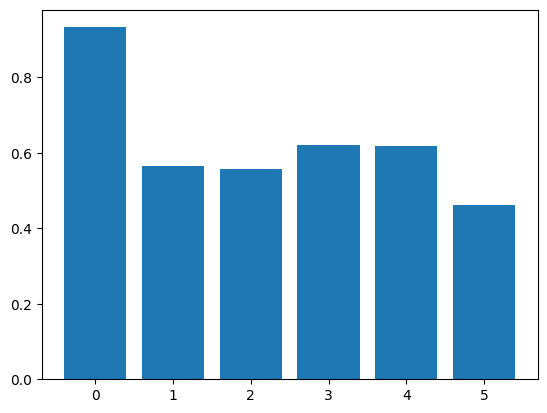

In [65]:
#accuracy bar plot for each category
accuracy = []
for cat in sorted(df["y_true"].round().astype(int).unique()):
    df_cat = df[df["y_true"].round().astype(int) == cat]
    accuracy.append((df_cat["y_true"].round() == df_cat["y_pred"].round()).mean())
plt.bar(sorted(df["y_true"].round().astype(int).unique()), accuracy)

print(accuracy)

In [66]:
from sklearn.metrics import roc_auc_score, root_mean_squared_error, mean_squared_error

Text(0.5, 1.0, 'Mean Squared Error for each week')

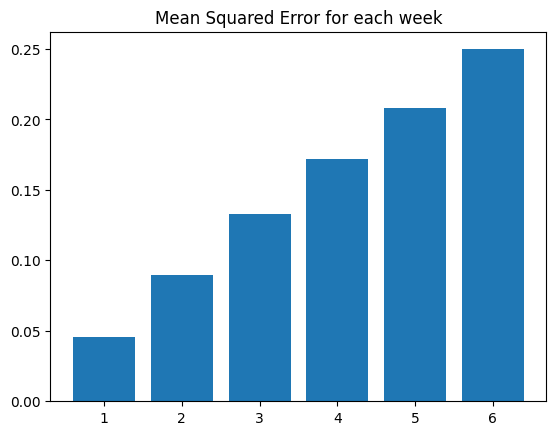

In [67]:
# MAE plot for each week
mse = []
for w in range(6):
    wdf = df[df['week']==w]
    mse.append(mean_squared_error(wdf['y_true'], wdf['y_pred']))
plt.bar(range(1,7), mse)
plt.title("Mean Squared Error for each week")

Text(0.5, 1.0, 'F1 score for each week')

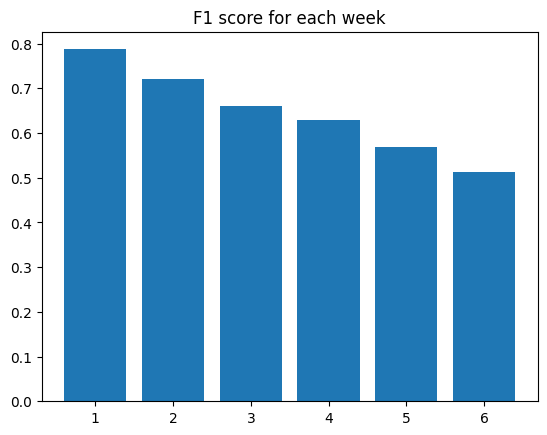

In [68]:
# F1 plot for each week
f1 = []
for w in range(6):
    wdf = df[df['week']==w]
    f1.append(f1_score(wdf['y_true'].round(),wdf['y_pred'].round(), average='macro'))
plt.bar(range(1,7), f1)
plt.title("F1 score for each week")

(array([1.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 8.000e+00, 3.000e+00, 1.100e+01, 7.000e+00, 1.600e+01,
        3.300e+01, 4.200e+01, 4.100e+01, 5.400e+01, 6.400e+01, 1.120e+02,
        1.430e+02, 2.410e+02, 3.020e+02, 6.850e+02, 1.610e+03, 6.326e+03,
        2.874e+03, 5.610e+02, 4.430e+02, 3.400e+02, 2.930e+02, 2.140e+02,
        1.270e+02, 7.700e+01, 4.600e+01, 2.100e+01, 1.600e+01, 1.500e+01,
        9.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([-3.58051825, -3.43161472, -3.28271119, -3.13380766, -2.98490414,
        -2.83600061, -2.68709708, -2.53819355, -2.38929003, -2.2403865 ,
        -2.09148297, -1.94257944, -1.79367592, -1.64477239, -1.49586886,
        -1.34696533, -1.19806181, -1.04915828, -0.90025475, -0.75135122,
        -0.6024477 , -0.45354417, -0.30464064, -0.15573711, -0.00683359,
         0.14206994,  0.29097347,  0.439877  ,  0.58878052,  0.73768405,
         0.88658758,  1.03549111,  1.18439463,  1.33329816,  1.4

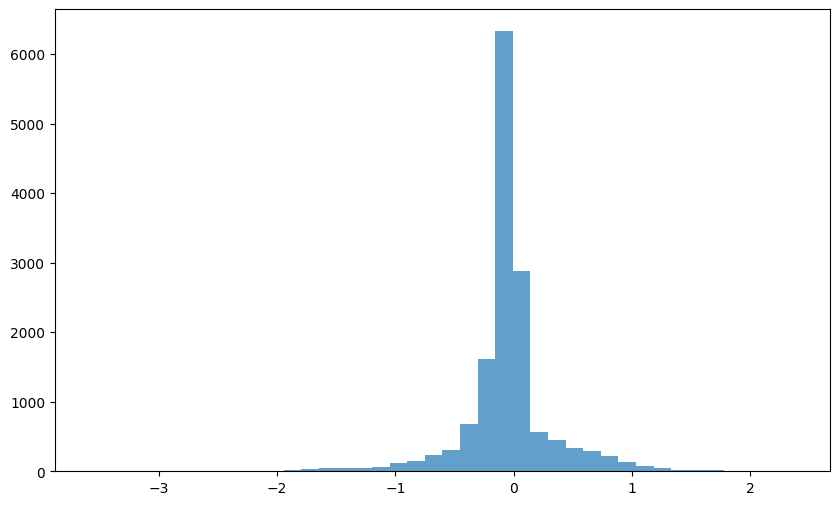

In [69]:
# Error distribution
plt.figure(figsize=(10, 6))
plt.hist(df['y_true'] - df['y_pred'], bins=40, alpha=0.7, label='error')

Text(0, 0.5, 'Residuals')

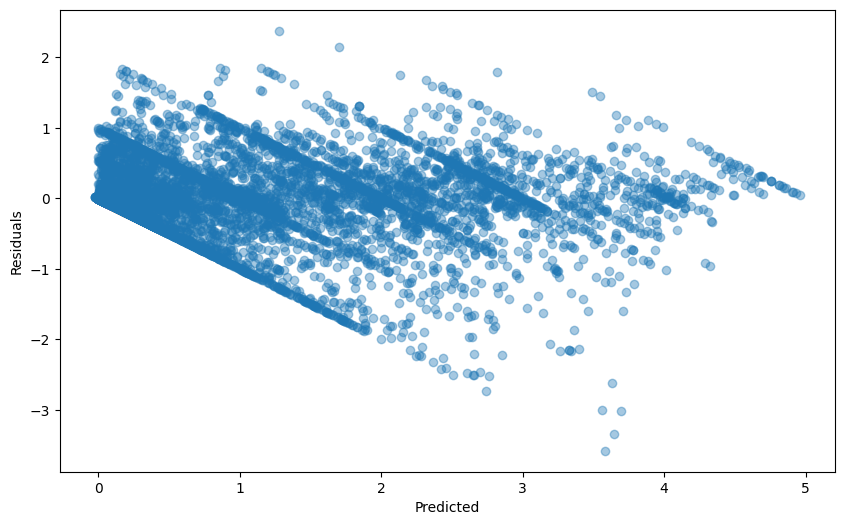

In [70]:
# predicted values vs residuals
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'] - df['y_pred'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("Residuals")

Text(0, 0.5, 'True')

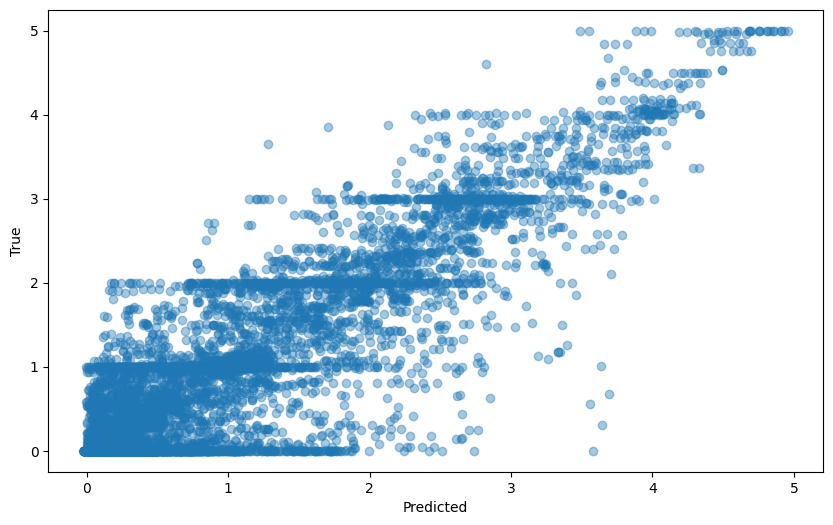

In [71]:
plt.figure(figsize=(10, 6))
plt.scatter(df['y_pred'], df['y_true'], alpha=0.4)
plt.xlabel("Predicted")
plt.ylabel("True")